In [9]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
import urllib.request
import bs4 as bs
import re

**Datos**

In [155]:
raw_html = urllib.request.urlopen('https://en.wikipedia.org/wiki/Leonardo_da_Vinci')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

In [156]:
print("Cantidad de caracteres en la nota:", len(article_text))

Cantidad de caracteres en la nota: 58434


In [157]:
# substituir con regex con espacio vacío:
text = re.sub(r'\[[0-9]*\]', ' ', article_text) # substituir los números entre corchetes
# (notar que los corchetes son interpretados literalmente por los backlsash)
text = re.sub(r'\s+', ' ', text) # substituir más de un caracter de espacio, salto de línea o tabulación

# probar en regex101 con los patrones anteriores:
# 'Hola [1], [], [ estoy bien   [123]. [12sss]. OK!

In [158]:
text

' leonardo di ser piero da vinci[b] (15 april 1452 – 2 may 1519) was an italian polymath of the high renaissance who was active as a painter, draughtsman, engineer, scientist, theorist, sculptor, and architect. while his fame initially rested on his achievements as a painter, he also became known for his notebooks, in which he made drawings and notes on a variety of subjects, including anatomy, astronomy, botany, cartography, painting, and paleontology. leonardo is widely regarded to have been a genius who epitomized the renaissance humanist ideal, and his collective works comprise a contribution to later generations of artists matched only by that of his younger contemporary by 23 years michelangelo buonarroti. born out of wedlock to a successful notary and a lower-class woman in, or near, vinci, he was educated in florence by the italian painter and sculptor andrea del verrocchio. he began his career in the city, but then spent much time in the service of ludovico sforza in milan. la

**Preprocesamiento**

In [159]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding


In [160]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(text)
# Vistazo general de los primeros tokens
tokens[:20]

['leonardo',
 'di',
 'ser',
 'piero',
 'da',
 'vinci',
 'b',
 '15',
 'april',
 '1452',
 '–',
 '2',
 'may',
 '1519',
 'was',
 'an',
 'italian',
 'polymath',
 'of',
 'the']

In [161]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 9468


In [162]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
train_len=4
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [163]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences


[['leonardo', 'di', 'ser', 'piero'],
 ['di', 'ser', 'piero', 'da'],
 ['ser', 'piero', 'da', 'vinci'],
 ['piero', 'da', 'vinci', 'b'],
 ['da', 'vinci', 'b', '15'],
 ['vinci', 'b', '15', 'april'],
 ['b', '15', 'april', '1452'],
 ['15', 'april', '1452', '–'],
 ['april', '1452', '–', '2'],
 ['1452', '–', '2', 'may'],
 ['–', '2', 'may', '1519'],
 ['2', 'may', '1519', 'was'],
 ['may', '1519', 'was', 'an'],
 ['1519', 'was', 'an', 'italian'],
 ['was', 'an', 'italian', 'polymath'],
 ['an', 'italian', 'polymath', 'of'],
 ['italian', 'polymath', 'of', 'the'],
 ['polymath', 'of', 'the', 'high'],
 ['of', 'the', 'high', 'renaissance'],
 ['the', 'high', 'renaissance', 'who'],
 ['high', 'renaissance', 'who', 'was'],
 ['renaissance', 'who', 'was', 'active'],
 ['who', 'was', 'active', 'as'],
 ['was', 'active', 'as', 'a'],
 ['active', 'as', 'a', 'painter'],
 ['as', 'a', 'painter', 'draughtsman'],
 ['a', 'painter', 'draughtsman', 'engineer'],
 ['painter', 'draughtsman', 'engineer', 'scientist'],
 ['draugh

In [164]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [165]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[8, 107, 106, 78],
 [107, 106, 78, 87],
 [106, 78, 87, 57],
 [78, 87, 57, 575],
 [87, 57, 575, 576],
 [57, 575, 576, 577],
 [575, 576, 577, 578],
 [576, 577, 578, 60],
 [577, 578, 60, 295],
 [578, 60, 295, 66],
 [60, 295, 66, 226],
 [295, 66, 226, 9],
 [66, 226, 9, 20],
 [226, 9, 20, 579],
 [9, 20, 579, 985],
 [20, 579, 985, 2],
 [579, 985, 2, 1],
 [985, 2, 1, 227],
 [2, 1, 227, 129],
 [1, 227, 129, 30],
 [227, 129, 30, 9],
 [129, 30, 9, 580],
 [30, 9, 580, 10],
 [9, 580, 10, 5],
 [580, 10, 5, 130],
 [10, 5, 130, 581],
 [5, 130, 581, 175],
 [130, 581, 175, 228],
 [581, 175, 228, 986],
 [175, 228, 986, 229],
 [228, 986, 229, 3],
 [986, 229, 3, 230],
 [229, 3, 230, 68],
 [3, 230, 68, 7],
 [230, 68, 7, 296],
 [68, 7, 296, 582],
 [7, 296, 582, 583],
 [296, 582, 583, 18],
 [582, 583, 18, 7],
 [583, 18, 7, 398],
 [18, 7, 398, 10],
 [7, 398, 10, 5],
 [398, 10, 5, 130],
 [10, 5, 130, 11],
 [5, 130, 11, 58],
 [130, 11, 58, 149],
 [11, 58, 149, 61],
 [58, 149, 61, 13],
 [149, 61, 13, 7],
 [61, 

**Input y target**

In [166]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(9464, 3)
(9464,)


In [167]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'in',
 5: 'a',
 6: 'to',
 7: 'his',
 8: 'leonardo',
 9: 'was',
 10: 'as',
 11: 'he',
 12: 'that',
 13: 'for',
 14: 'with',
 15: 'by',
 16: "leonardo's",
 17: 'is',
 18: 'on',
 19: 'were',
 20: 'an',
 21: 'painting',
 22: 'at',
 23: 'it',
 24: 'from',
 25: 'have',
 26: 'which',
 27: 'be',
 28: 'or',
 29: 'this',
 30: 'who',
 31: 'been',
 32: 'milan',
 33: 'him',
 34: 'work',
 35: 'had',
 36: 'c',
 37: 'made',
 38: 'one',
 39: 'other',
 40: 'are',
 41: 'drawings',
 42: 'works',
 43: 'not',
 44: 'many',
 45: 'most',
 46: 'studies',
 47: 'florence',
 48: 'time',
 49: 'such',
 50: 'but',
 51: 'art',
 52: 'vasari',
 53: 'so',
 54: 'saint',
 55: 'some',
 56: 'these',
 57: 'vinci',
 58: 'also',
 59: 'much',
 60: '–',
 61: 'known',
 62: 'all',
 63: 'when',
 64: 'its',
 65: '‡',
 66: 'may',
 67: 'their',
 68: 'while',
 69: 'including',
 70: 'anatomy',
 71: 'only',
 72: 'years',
 73: 'death',
 74: 'there',
 75: 'drawing',
 76: 'about',
 77: 'wrote',
 78: 'piero

In [168]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2625

In [169]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(9464, 2625)

**Entrenar el modelo**

In [170]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [171]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2625

In [172]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 3, 5)              13130     
                                                                 
 lstm_10 (LSTM)              (None, 3, 64)             17920     
                                                                 
 dropout_7 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 2625)              86625     
                                                                 
Total params: 152779 (596.79 KB)
Trainable params: 152

In [173]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
237/237 [==============================] - 12s 21ms/step - loss: 6.9177 - accuracy: 0.0655 - val_loss: 6.9743 - val_accuracy: 0.0592
Epoch 2/50
237/237 [==============================] - 4s 15ms/step - loss: 6.3447 - accuracy: 0.0662 - val_loss: 7.2281 - val_accuracy: 0.0592
Epoch 3/50
237/237 [==============================] - 6s 23ms/step - loss: 6.2759 - accuracy: 0.0662 - val_loss: 7.3971 - val_accuracy: 0.0592
Epoch 4/50
237/237 [==============================] - 4s 15ms/step - loss: 6.2226 - accuracy: 0.0662 - val_loss: 7.7886 - val_accuracy: 0.0592
Epoch 5/50
237/237 [==============================] - 4s 15ms/step - loss: 6.1822 - accuracy: 0.0663 - val_loss: 7.6598 - val_accuracy: 0.0586
Epoch 6/50
237/237 [==============================] - 4s 18ms/step - loss: 6.1398 - accuracy: 0.0662 - val_loss: 7.8509 - val_accuracy: 0.0592
Epoch 7/50
237/237 [==============================] - 5s 21ms/step - loss: 6.1041 - accuracy: 0.0663 - val_loss: 7.9099 - val_accuracy: 0.057

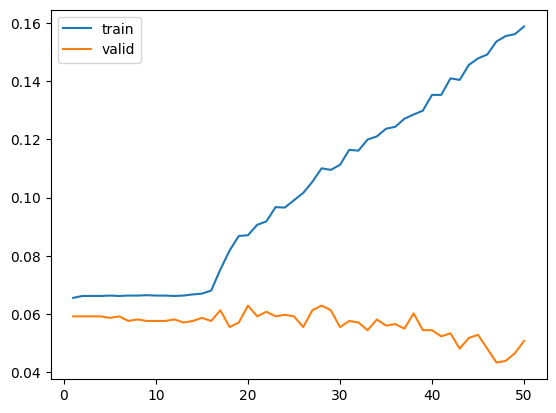

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

**Predicción de próxima palabra**

In [126]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [74]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

ImportError: ignored

**Generación de secuencias nuevas**

In [175]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text


In [178]:
input_text='Leonardo was a'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 146ms/step


'Leonardo was a study the'